### Visualizing the distribution of the observations

### Load the required libraries

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSSSBSBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib


/home/sai/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12816
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     1|[C8 5A E8 59 F0 5...|1897.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[80 58 00 00 20 5...|1898.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[60 59 00 53 40 5...|1899.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     6|[00 C6 00 4F 00 4...|1900.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[28 58 40 56 30 5...|1901.0|BSSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [4]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('SNWD')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='SNWD'
2266 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     78.3| 32.5906| -86.2103|       SNWD|USC00018859|     1|[00 00 00 00 00 0...|1949.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       SNWD|USC00018859|     0|[00 00 00 00 00 0...|1950.0|BSSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(2266, 365)


# Data by the years

### Number of readings across years

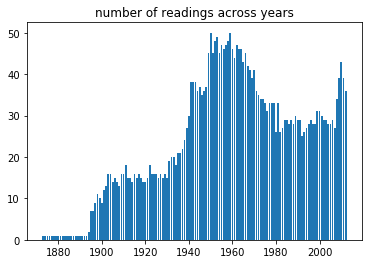

In [205]:
x = df2.rdd.map(lambda row:(row['year'])).collect()
y = df2.rdd.map(lambda row:(row['count(station)'])).collect()
# import plotly.plotly as py
import matplotlib.pyplot as plt

date = plt.figure()

# x = [datetime.datetime(2010, 12, 1, 10, 0),
#     datetime.datetime(2011, 1, 4, 9, 0),
#     datetime.datetime(2011, 5, 5, 9, 0)]
# y = [4, 9, 2]

ax = plt.subplot(111)
ax.bar(x, y)
plt.title('number of readings across years')
# ax.xaxis_date()
plt.show()
# plot_url = py.plot_mpl(date, filename='mpl-date-example')

We see that the number of observations are relatively less before 1900 and most of the observations are made after 1940

### geolocation

In [266]:
loc = df.rdd.map(lambda row: (row['latitude'],row['longitude'],row['elevation'])).collect()
loc = list(set(loc))
latitudes = [x for (x,y,z) in loc]
longitudes = [y for (x,y,z) in loc]
elevations = [int(z) for (x,y,z) in loc]

In [277]:
import gmplot

gmap = gmplot.GoogleMapPlotter(32.5906, -86.2103,8)

gmap.scatter(latitudes, longitudes, 'cornflowerblue')
# gmap.scatter(more_lats, more_lngs, '#3B0B39', size=40, marker=False)
# gmap.scatter(marker_lats, marker_lngs, 'k', marker=True)
# gmap.heatmap(heat_lats, heat_lngs)
gmap.draw("mymap.html")
# from IPython.display import IFrame
# IFrame('mymap.html', width=700, height=350)


### variation of mean of parameters over years

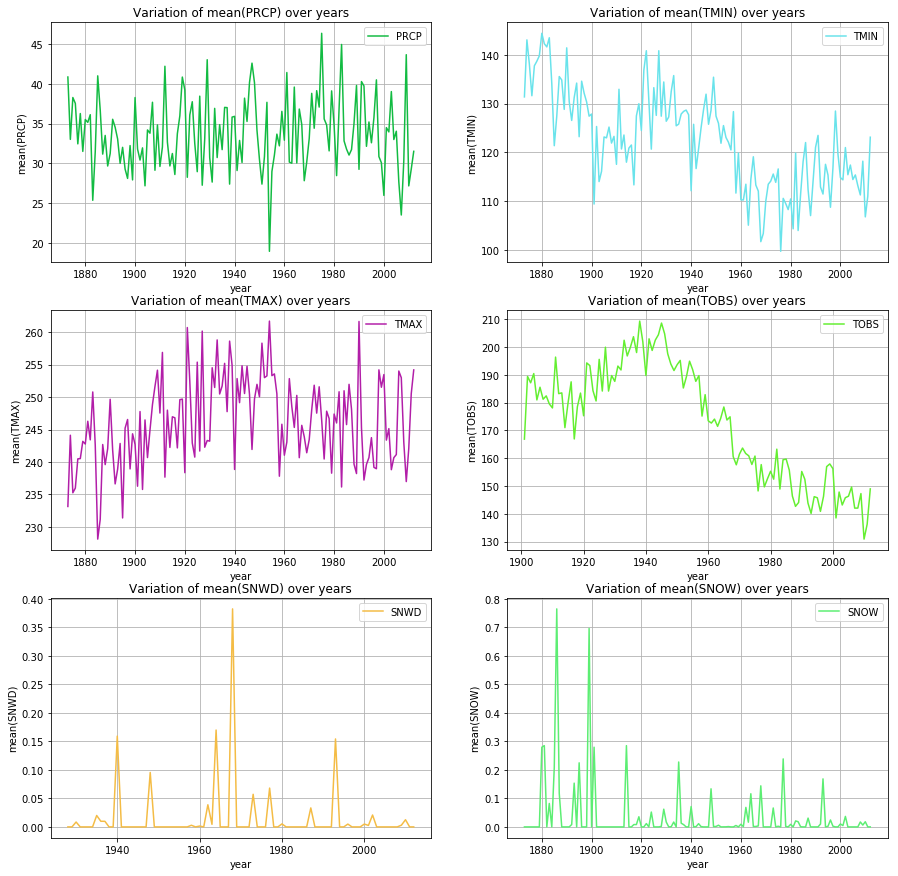

In [226]:
import random
param = ['PRCP','TMIN','TMAX','TOBS','SNWD','SNOW']
j = 0
plt.figure(figsize=(15,15))
for p in param:
    subplot(3,2,j+1)
    j += 1
    df1=df.filter(df.measurement==p)
#     df1.show()
    data=df1.rdd.map(lambda row: (row['year'],np.nanmean(np.float32(unpackArray(row['vector'],np.float16)))))
#     data=df1.rdd.map(lambda row: (row['year'],np.sum(unpackArray(row['vector'],np.float16))))
#     print data.collect()
#     print data.count()
#     print data.take(5)
    temp = data.groupByKey().mapValues(lambda x:mean([a for a in x])).collect()
#     print temp[5]
    temp.sort()
    x = [a for (a,b) in temp]
    y1 = [b for (a,b) in temp]
    c = "#%06x" % random.randint(0, 0xFFFFFF)
    plt.plot(x,y1,color=c)
    plt.title('Variation of mean('+p+') over years')
    plt.legend([p])
    plt.xlabel('year')
    plt.ylabel('mean(' + p + ')')
    grid()

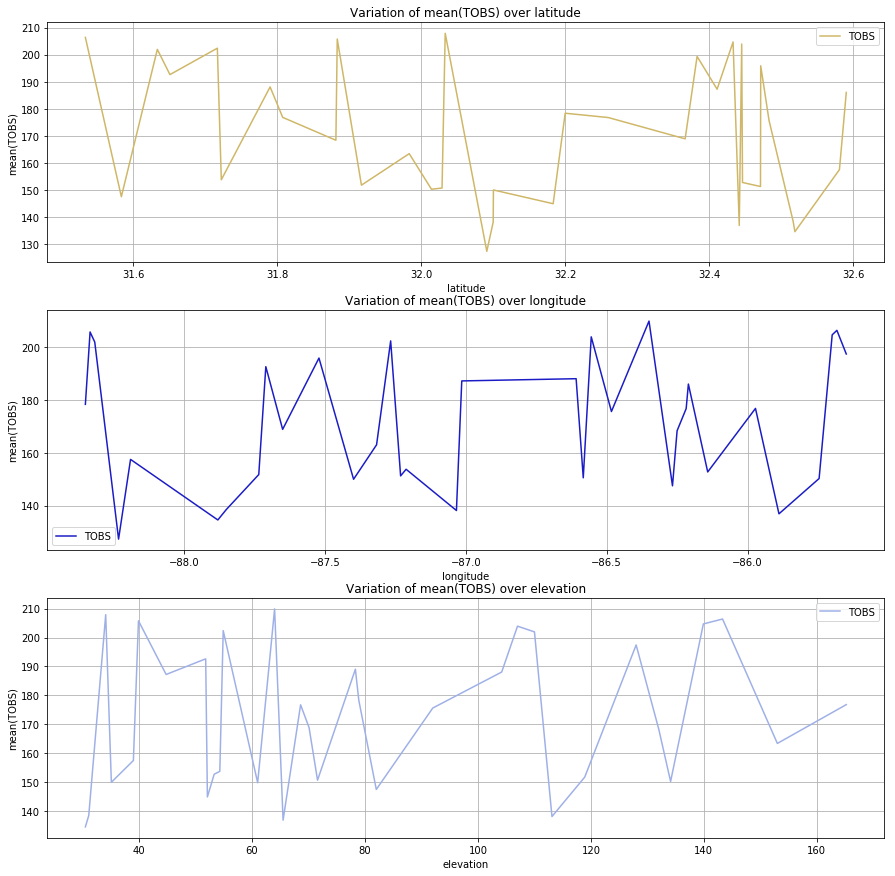

In [6]:
import random
param = ['latitude','longitude','elevation']
j = 0
plt.figure(figsize=(15,15))
for p in param:
    subplot(3,1,j+1)
    j += 1
    df1=df.filter(df.measurement=='TOBS')
#     df1.show()
    data=df1.rdd.map(lambda row: (row[p],np.nanmean(np.float32(unpackArray(row['vector'],np.float16)))))
#     data=df1.rdd.map(lambda row: (row['year'],np.sum(unpackArray(row['vector'],np.float16))))
#     print data.collect()
#     print data.count()
#     print data.take(5)
    temp = data.groupByKey().mapValues(lambda x:mean([a for a in x])).collect()
#     print temp[5]
    temp.sort()
    x = [a for (a,b) in temp]
    y1 = [b for (a,b) in temp]
    c = "#%06x" % random.randint(0, 0xFFFFFF)
    plt.plot(x,y1,color=c)
    plt.title('Variation of mean(TOBS) over '+ p)
    plt.legend(['TOBS'])
    plt.xlabel(p)
    plt.ylabel('mean(TOBS)')
    grid()

### Data with in a year

In [64]:
from YearPlotter import YearPlotter
# fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
# YP.plot(mean(T[:5,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

In [102]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)
    axis.legend([m + '- std',m,m+'+ std'],loc='upper right')

In [103]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

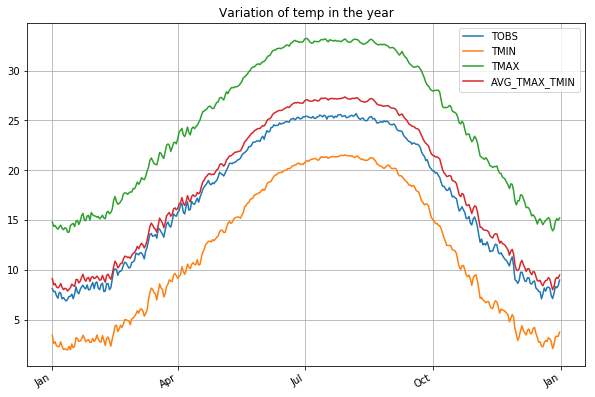

In [207]:
avg_min_max = np.array(STAT['TMIN']['Mean'])*0.05 + np.array(STAT['TMAX']['Mean'])*0.05
graphs=np.vstack([np.array(STAT['TOBS']['Mean'])*0.1,np.array(STAT['TMIN']['Mean'])*0.1,np.array(STAT['TMAX']['Mean'])*0.1,avg_min_max]).transpose()
fig, ax = plt.subplots(figsize=(10,7))
YP.plot(graphs,fig,ax,title='Variation of temp in the year')
plt.legend(['TOBS','TMIN','TMAX','AVG_TMAX_TMIN'])

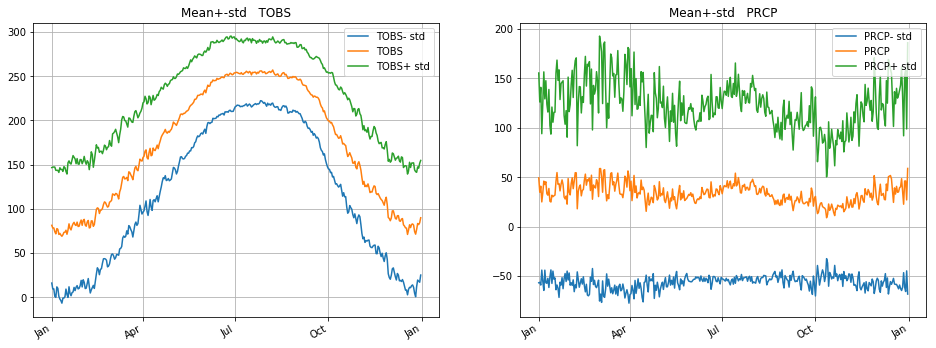

In [208]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

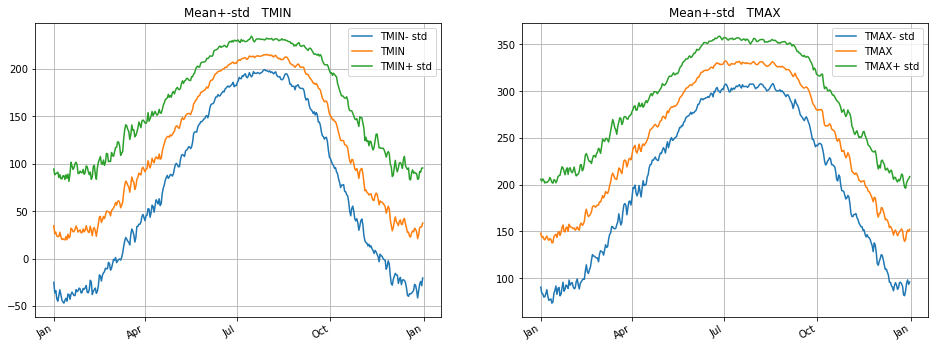

In [209]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

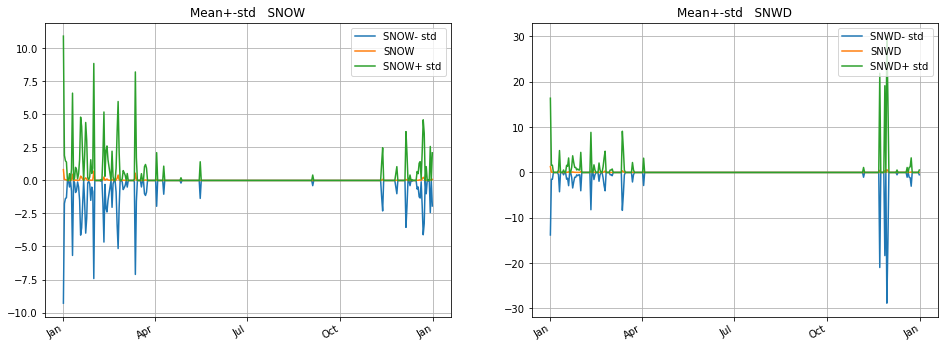

In [108]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

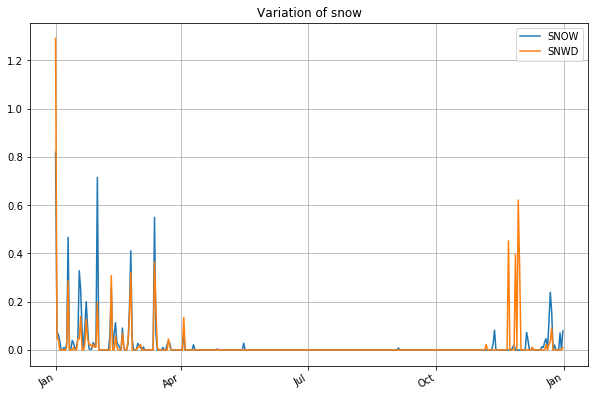

In [210]:
fig, ax = plt.subplots(figsize=(10,7))
YP.plot(np.vstack([STAT['SNOW']['Mean'],STAT['SNWD']['Mean']]).transpose(),fig,ax,title='Variation of snow')
plt.legend(['SNOW','SNWD'])#,'TMIN','TMAX','AVG_TMAX_TMIN'])

### Plotting eigen values

In [211]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

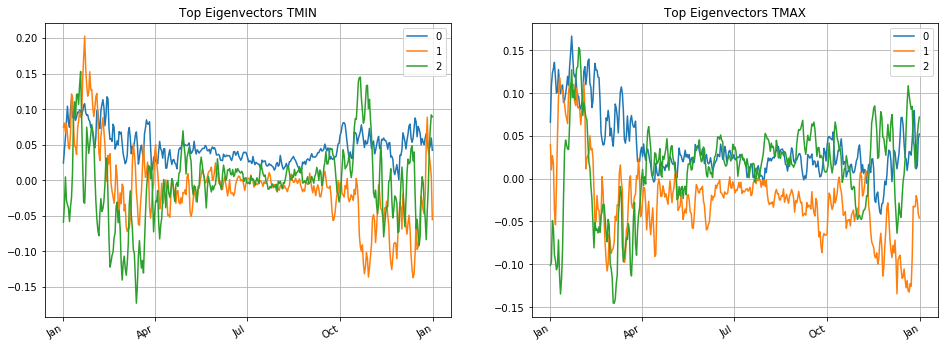

In [212]:
plot_pair(['TMIN','TMAX'],plot_eigen)

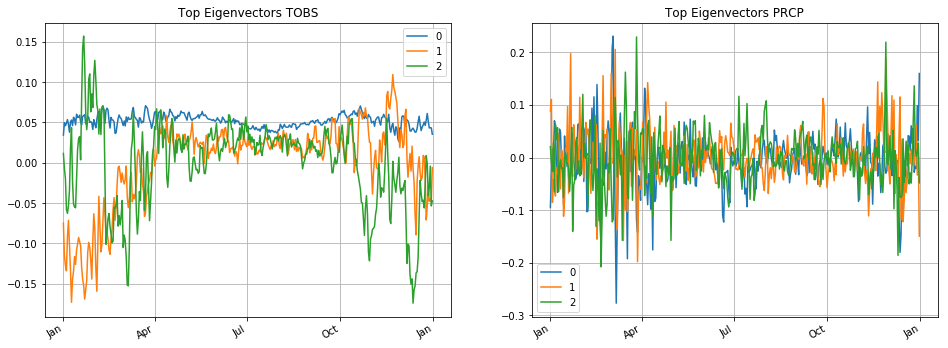

In [213]:
plot_pair(['TOBS','PRCP'],plot_eigen)

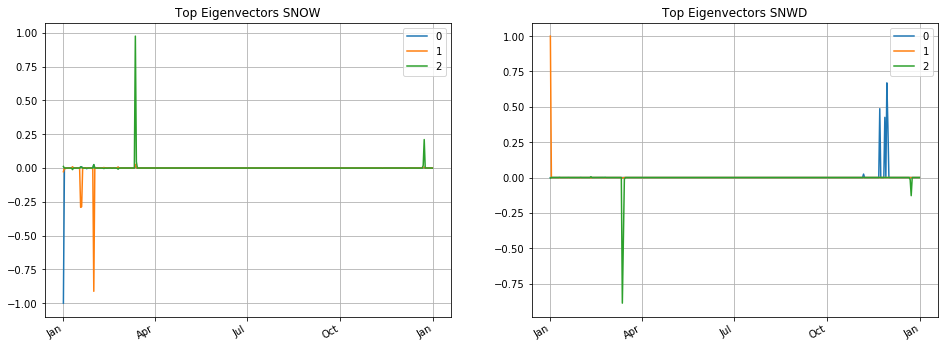

In [214]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [215]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

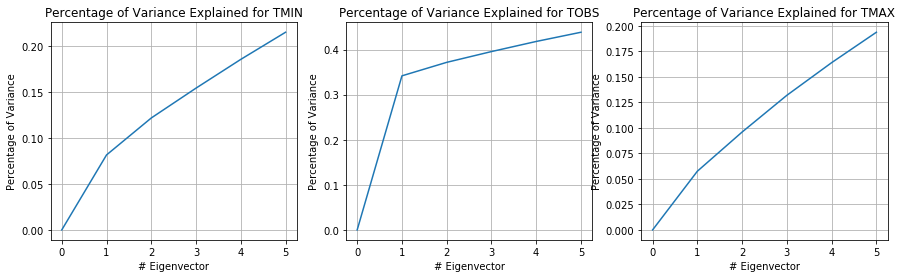

In [216]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

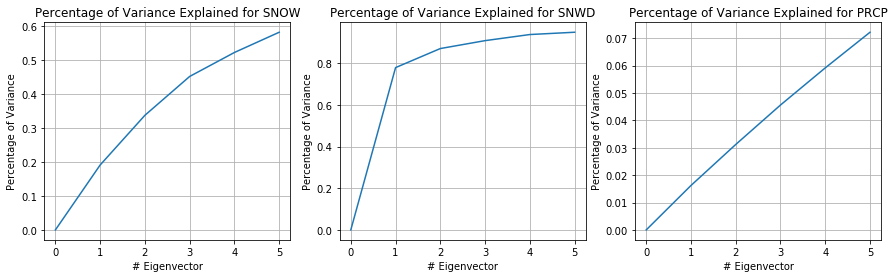

In [217]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()